In [1]:
#Kuhan Wang 17-09-15
#This code is mostly cribbed from tutorials from Matvey Ezhov's Github
#at https://github.com/ematvey/tensorflow-seq2seq-tutorials

#Modifications have been made to allow for the encoder and decoders to be stacked
#into multiple layers and to output the inference probabilities.
#In addition, as opposed Ezhov's original copy task example, the hyperparameters
#have been tuned to apply to a more realistic language model problem.

#Otherwise, the code implements a bidirectional seq2seq model with attention as
#laid out in Ezhov's original tutorial.

#This code is successfully executed on tensorflow 1.0 with python 3.5
#Benchmark language models can be trained within 2-3 days on a single Tesla K10.

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import pandas as pd

import helpers
import math
import pickle
import random

def devCheck(dev_encoded_text, dev_decoded_text, inf_dev):

        fd_inf = make_inference_inputs([i for i in dev_encoded_text])

        if inf_dev == True:
            
            inf_out = session.run(decoder_prediction_inference, fd_inf)
            inf_prob_out = session.run(decoder_prediction_prob_inference, fd_inf)

            for (idx, pred) in enumerate(zip(inf_out.T, inf_prob_out.T)):

                print ('INFERENCE EXAMPLE: ', idx)
                print ('encode in', [inv_map[i] for i in dev_encoded_text[idx]])
                print ('decode in', [inv_map[i] for i in dev_decoded_text[idx]])

                print ('inference text out', [inv_map[i] for i in pred[0]])
                print ('inference out prob', pred[1][idx])

                if idx>1: break

            return inf_out, inf_prob_out
        
        else:

            return fd_inf

def make_train_inputs(input_seq, target_seq):
    inputs_, inputs_length_ = helpers.batch(input_seq)
    targets_, targets_length_ = helpers.batch(target_seq)
    
    return {
        encoder_inputs: inputs_,
        encoder_inputs_length: inputs_length_,
        decoder_targets: targets_,
        decoder_targets_length: targets_length_,
    }

def make_inference_inputs(input_seq):
    inputs_, inputs_length_ = helpers.batch(input_seq)

    return {
        encoder_inputs: inputs_,
        encoder_inputs_length: inputs_length_,
    }

def numericEncode(sent):

    if type(sent) == str: sent = sent.split(' ')
    
    return [vocab_dict[word] if word in vocab_dict else 2 for word in sent]

def decodeSent(sent):
    return [inv_map[i] for i in sent]

def predictionCheck(mean_metric):

    df_metric = pd.DataFrame(mean_metric, columns=['input', 'truth', 'inference', 'inference_prob', 'epoch', 'batch'])

    checkListResults = list(map(checkList, df_metric['truth'].values, df_metric['inference'].values))

    df_metric['input_sent'] = df_metric['input'].apply(decodeSent)

    df_metric['truth_sent'] = df_metric['truth'].apply(decodeSent)
    df_metric['inference_sent'] = df_metric['inference'].apply(decodeSent)
    df_metric['checkList'] = checkListResults

    df_metric['meanCheckList'] = df_metric['checkList'].apply(np.mean)
    
    return df_metric

def checkList(x, y):
    
    len_y = len(y)
    len_x = len(x)
    
    matching = [x[i]==y[i] if i<len_y else False for i in range(len_x)]
    
    return matching

In [2]:
tf.__version__

'1.0.0'

In [3]:
#df_all = pd.read_pickle('processed_data_v01_EN-DE_py35_seq_length_5_15_sample_540659_limited_vocab.pkl')
#vocab_dict = pickle.load(open('word_dict_v01_EN-DE_py35_seq_length_5_15_sample_540659_limited_vocab.pkl', 'rb'))

df_all = pd.read_pickle('processed_data\processed_data_v01_enron_py35_seq_length_3_49_sample_4256_limited_vocab.pkl')
vocab_dict = pickle.load(open('dicts\word_dict_v01_enron_py35_seq_length_3_49_sample_4256_limited_vocab.pkl', 'rb'))

#Encode sequences
df_all['alpha_Pair_1_encoding'] =  df_all['alpha_Pair_1_tokens'].apply(numericEncode)
df_all['alpha_Pair_0_encoding'] = df_all['alpha_Pair_0_tokens'].apply(numericEncode)

df_all['Index'] = df_all.index.values

df_all_train = df_all.sample(frac=0.90, random_state=0)

df_all_dev = df_all[df_all['Index'].isin(df_all_train['Index'].values) == False]

inv_map = {v: k for k, v in vocab_dict.items()}

dev_encoded_text = df_all_dev['alpha_Pair_0_encoding'].values
dev_decoded_text = df_all_dev['alpha_Pair_1_encoding'].values

In [4]:
df_all_train.shape, df_all_dev.shape, len(vocab_dict)

((3830, 5), (58, 5), 7239)

In [5]:
tf.reset_default_graph()

PAD = 0
EOS = 1

vocab_size = len(vocab_dict) 
input_embedding_size = 256

length_from = 3
length_to = 49
vocab_lower = 0
vocab_upper = vocab_size
n_batch_size = 32

batches_in_epoch = df_all_train.shape[0]/n_batch_size

n_cells = 128
num_layers = 2

n_epochs = 1000


In [6]:
batches_in_epoch

119.6875

In [7]:
copy_batches = helpers.random_sequences(length_from=length_from, length_to=length_to,
                                       vocab_lower=vocab_lower, vocab_upper=vocab_size,
                                       batch_size=n_batch_size)

In [8]:
#Create handles for encoder and decoders
encoder_inputs = tf.placeholder(
            shape=(None, None),
            dtype=tf.int32,
            name='encoder_inputs',
        )

encoder_inputs_length = tf.placeholder(
            shape=(None,),
            dtype=tf.int32,
            name='encoder_inputs_length',
        )

# required for training, not required for testing
decoder_targets = tf.placeholder(
            shape=(None, None),
            dtype=tf.int32,
            name='decoder_targets'
        )

decoder_targets_length = tf.placeholder(
            shape=(None,),
            dtype=tf.int32,
            name='decoder_targets_length',
        )

In [9]:
sequence_size, batch_size = tf.unstack(tf.shape(decoder_targets))

In [10]:
#Make EOS and PAD matrices to concatenate with targets
EOS_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * EOS
PAD_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * PAD

In [11]:
#Adding EOS to the beginning of the decoder targets
decoder_train_inputs = tf.concat([EOS_SLICE, decoder_targets], axis=0)
decoder_train_length = decoder_targets_length + 1

In [12]:
decoder_train_targets = tf.concat([decoder_targets, PAD_SLICE], axis=0)

In [13]:
decoder_train_targets_seq_len, _ = tf.unstack(tf.shape(decoder_train_targets))

In [14]:
#Pad out the decoder matrix to be time major
#Which decoder matrix? must be in input?
#This puts the EOS in the correct position and puts zeroes else, then the actual encoded seq is added on?
decoder_train_targets_eos_mask = tf.one_hot(decoder_train_length - 1,
                                                        decoder_train_targets_seq_len,
                                                        on_value=EOS, off_value=PAD,
                                                        dtype=tf.int32)

In [15]:
#Why are we transposing here?
decoder_train_targets_eos_mask = tf.transpose(decoder_train_targets_eos_mask, [1, 0])

In [16]:
#Yep looks like it, add the decoder targets and the Padded matrix to create the time major matrix
decoder_train_targets = tf.add(decoder_train_targets,
                                           decoder_train_targets_eos_mask)

In [17]:
#One parameter characterizing the weight in each target? Make the length equal to the longest sequence in the batch
loss_weights = tf.ones([batch_size, 
                        tf.reduce_max(decoder_train_length)], 
                        dtype=tf.float32, name="loss_weights")

In [18]:
#Create word embeddings
sqrt3 = math.sqrt(3)
initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)

#Randomly initialize a embedding vector for each term in the vocabulary
embedding_matrix = tf.get_variable(name="embedding_matrix", shape=[vocab_size, input_embedding_size],
                                    initializer=initializer, dtype=tf.float32)

In [19]:
#Map each input unit to a column in the embedding matrix
encoder_inputs_embedded = tf.nn.embedding_lookup(embedding_matrix, encoder_inputs)

decoder_train_inputs_embedded = tf.nn.embedding_lookup(embedding_matrix, decoder_train_inputs)

In [20]:
#Create a bi-directional encoder, encoding the forward and backward states
#The core abstraction is in tf.nn.bidirectional_dynamic_rnn!
#The encoder_cell is the LSTM itself
#Here cell refers to all the units?

In [21]:
encoder_output_keep = 1
decoder_output_keep = 1

In [22]:
encoder_cell_fw = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(n_cells), input_keep_prob=1, 
                                             output_keep_prob=encoder_output_keep)

#encoder_cell = tf.contrib.rnn.LSTMCell(n_cells)
encoder_cell_fw = tf.contrib.rnn.MultiRNNCell([encoder_cell_fw for _ in range(num_layers)])

In [23]:
encoder_cell_bw = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(n_cells), input_keep_prob=1, 
                                             output_keep_prob=encoder_output_keep)

#encoder_cell = tf.contrib.rnn.LSTMCell(n_cells)
encoder_cell_bw = tf.contrib.rnn.MultiRNNCell([encoder_cell_bw for _ in range(num_layers)])

In [24]:
decoder_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(n_cells*2), input_keep_prob=1, 
                                             output_keep_prob=decoder_output_keep)

#decoder_cell = tf.contrib.rnn.LSTMCell(n_cells*2)
decoder_cell = tf.contrib.rnn.MultiRNNCell([decoder_cell for _ in range(num_layers)])

In [25]:
#encoder_cell.state_size, encoder_inputs_embedded, encoder_inputs_length

In [26]:
(
 (encoder_fw_outputs, encoder_bw_outputs),
 (encoder_fw_state, encoder_bw_state)
) = (
     tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell_fw, 
                                     cell_bw=encoder_cell_bw,
                                     inputs=encoder_inputs_embedded,
                                     sequence_length=encoder_inputs_length,
                                     time_major=True, dtype=tf.float32)
    )

In [27]:
#concatenate backward and forward outputs
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

In [28]:

#encoder_state_c = tf.concat((encoder_fw_state.c, encoder_bw_state.c), 1, name='bidirectional_concat_c')
#encoder_state_h = tf.concat((encoder_fw_state.h, encoder_bw_state.h), 1, name='bidirectional_concat_h')
    

In [29]:
#encoder_state = tf.contrib.rnn.LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)


In [30]:
encoder_state = []

for i in range(num_layers):
    
   # if isinstance(encoder_fw_state[i], tf.contrib.rnn.LSTMStateTuple):

    encoder_state_c = tf.concat((encoder_fw_state[i].c, encoder_bw_state[i].c), 1, name='bidirectional_concat_c')
    encoder_state_h = tf.concat((encoder_fw_state[i].h, encoder_bw_state[i].h), 1, name='bidirectional_concat_h')
    
    current_encoder_state = tf.contrib.rnn.LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)

   #elif isinstance(encoder_fw_state[i], tf.Tensor):
   #current_encoder_state = tf.concat((encoder_fw_state[i], encoder_bw_state[i]), 1, name='bidirectional_concat')
    
    encoder_state.append(current_encoder_state)

encoder_state = tuple(encoder_state)

In [31]:
attention_states = tf.transpose(encoder_outputs, perm=[1, 0, 2])

In [32]:
#What is the purpose of scope?

with tf.variable_scope('Decoder') as scope:

    def output_fn(outputs):
        return tf.contrib.layers.linear(outputs, vocab_size, scope=scope)
 
    attention_states = tf.transpose(encoder_outputs, perm=[1, 0, 2])

    (
        attention_keys,
        attention_values,
        attention_score_fn,
        attention_construct_fn
    ) = tf.contrib.seq2seq.prepare_attention(
                        attention_states=attention_states,
                        attention_option="bahdanau",
                        num_units=decoder_cell.output_size) 

    decoder_fn_train = tf.contrib.seq2seq.attention_decoder_fn_train(
                        encoder_state=encoder_state,
                        attention_keys=attention_keys,
                        attention_values=attention_values,
                        attention_score_fn=attention_score_fn,
                        attention_construct_fn=attention_construct_fn,
                        name='attention_decoder')

    decoder_fn_inference = tf.contrib.seq2seq.attention_decoder_fn_inference(
                        output_fn=output_fn,
                        encoder_state=encoder_state,
                        attention_keys=attention_keys,
                        attention_values=attention_values,
                        attention_score_fn=attention_score_fn,
                        attention_construct_fn=attention_construct_fn,
                        embeddings=embedding_matrix,
                        start_of_sequence_id=EOS,
                        end_of_sequence_id=EOS,
                        maximum_length=tf.reduce_max(encoder_inputs_length) + 3,
                        num_decoder_symbols=vocab_size
                    )

    (
     decoder_outputs_train,
     decoder_state_train,
     decoder_context_state_train
    ) = (tf.contrib.seq2seq.dynamic_rnn_decoder(
                                           cell=decoder_cell,
                                           decoder_fn=decoder_fn_train,
                                           inputs=decoder_train_inputs_embedded,
                                           sequence_length=decoder_train_length,
                                           time_major=True, scope=scope,
                )
            )

    decoder_logits_train = output_fn(decoder_outputs_train)

    decoder_prediction_train = tf.argmax(decoder_logits_train, axis=-1, name='decoder_prediction_train')
    
    
    scope.reuse_variables()

    (decoder_logits_inference,
     decoder_state_inference,
     decoder_context_state_inference) = (
        tf.contrib.seq2seq.dynamic_rnn_decoder(
            cell=decoder_cell,
            decoder_fn=decoder_fn_inference,
            time_major=True,
           scope=scope,
        )
    )
    
    decoder_prediction_inference = tf.argmax(decoder_logits_inference, axis=-1, name='decoder_prediction_inference')
   
    decoder_prediction_prob_inference = tf.nn.softmax(decoder_logits_inference, name='decoder_prediction_prob_inference')

In [33]:
#Create optimizer

logits = tf.transpose(decoder_logits_train, [1, 0, 2])
targets = tf.transpose(decoder_train_targets, [1, 0])

In [34]:
loss = tf.contrib.seq2seq.sequence_loss(logits=logits, targets=targets,
                                  weights=loss_weights)

In [35]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, \
                                           n_epochs*int(batches_in_epoch), 0.0001, staircase=False)

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss, global_step=global_step)

In [37]:
loss_track = []
dev_loss_track = []

In [38]:
copy_task = False

In [ ]:
all_weights = []
dev_test_results = []
metric_results = []
with tf.Session() as session:
    
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(session, \
    #    './seq2seq_CornelMovies_encode_100_decode_200_vocab_13679_embedding_200_seq_5_15_batch_64_layers_3_v5-210')
    #saver.restore(session, \
    #    './seq2seq_CornelMovies_encode_100_decode_200_vocab_13679_embedding_200_seq_5_15_batch_64_layers_3_v5-100')
    #saver.restore(session, \
    #    'd:\coding\seq2seq_CornelMovies_encode_200_decode_400_vocab_13679_embedding_200_seq_5_15_batch_128_layers_6_v6-990')
    #saver.restore(session, \
    #    './seq2seq_CornelMovies_encode_500_decode_1000_vocab_13679_embedding_1024_seq_5_15_batch_32_layers_6_v6-30')
    #saver.restore(session, \
    #'d:\coding\chkpt\seq2seq_Cornell_encode_128_decode_256_vocab_13679_embedding_256_seq_5_15_batch_32_layers_3_enkeep_10_dekeep_10-203320')
   #saver.restore(session, \
   # 'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10-12019')
    
    
    for epoch in range(n_epochs):
        
        df_all_train = df_all_train.sample(frac=1, random_state=0)#tf.train.global_step(session, global_step))
       
        encoded_text = df_all_train['alpha_Pair_0_encoding'].values
        decoded_text = df_all_train['alpha_Pair_1_encoding'].values
        text_index = df_all_train['Index'].values

        input_batches = ([encoded_text[block_idx*n_batch_size:(block_idx+1)*n_batch_size], 
                  decoded_text[block_idx*n_batch_size:(block_idx+1)*n_batch_size], 
                         text_index[block_idx*n_batch_size:(block_idx+1)*n_batch_size]]\
                    for block_idx in range(len(encoded_text)))
        
        for batch in range(int(batches_in_epoch)):
            mean_metric_train = []
            mean_metric_dev = []

            if copy_task == False:
                
                epoch_batches = next(input_batches)
                
                #input_batch_data = next(encoding_batches)
                #target_batch_data = next(decoding_batches)
                
                input_batch_data = epoch_batches[0]
                target_batch_data = epoch_batches[1]
                batch_data_index = epoch_batches[2]

            else:
                input_batch_data = next(copy_batches)
                target_batch_data = input_batch_data
            
            fd = make_train_inputs(input_batch_data, target_batch_data)
            #by randomizing the batches are not really comparable
            df_all_dev_check = df_all_dev.sample(n=32, random_state=0)
            
            dev_encoded_text = df_all_dev_check['alpha_Pair_0_encoding'].values
            dev_decoded_text = df_all_dev_check['alpha_Pair_1_encoding'].values
            #Don't think this makes sense without masking?
            #fd_dev = make_train_inputs([i for i in dev_encoded_text], [i for i in dev_decoded_text])

            _, l = session.run([train_op, loss], fd)
            loss_track.append(l)
            
            if batch % 500 == 0: 
                
                print ('global_step: %s' % tf.train.global_step(session, global_step))
                print ('learning rate', session.run(optimizer._lr))
                
                print ('epoch', epoch)
                print ('batch {}'.format(batch))
                #WHAT DOES THIS LOSS ACTUALLY MEAN? IS THIS TRAINING AGAINST GRAPH AGAIN? NO?
                print ('training minibatch loss: {}'.format(session.run(loss, fd)))
                #dev_loss = session.run(loss, fd_dev)
                #print ('dev loss: {}'.format(dev_loss))
                #dev_loss_track.append(dev_loss)
                
                for i, (e_in, dt_targ, dt_pred) in enumerate(zip(fd[encoder_inputs].T, 
                                                                 fd[decoder_targets].T, 
                                                                 session.run(decoder_prediction_train, fd).T)):

                    print('  sample {}:'.format(i + 1))
                    print('    Index', batch_data_index[i])
                    print('    enc input           > {}'.format(e_in))
                    print('    enc input           > {}'.format(' '.join([inv_map[i] for i in e_in])))

                    print('    dec input           > {}'.format(dt_targ))
                    print('    dec input           > {}'.format(' '.join([inv_map[i] for i in dt_targ])))

                    print('    dec train predicted > {}'.format(dt_pred))
                    print('    dec train predicted > {}'.format(' '.join([inv_map[i] for i in dt_pred])))
                
                    if i >= 0: break
                
                fd_inf_train = make_inference_inputs(input_batch_data)
                fd_inf_dev = make_inference_inputs(dev_encoded_text)

                inf_train_out = session.run(decoder_prediction_inference, fd_inf_train)
                inf_train_prob_out = session.run(decoder_prediction_prob_inference, fd_inf_train)
             
                inf_dev_out = session.run(decoder_prediction_inference, fd_inf_dev)
                inf_dev_prob_out = session.run(decoder_prediction_prob_inference, fd_inf_dev)
                
                for i, (pred, pred_prob) in enumerate(zip(inf_train_out.T, inf_train_prob_out.T)):
                #    print ('inference out', pred)
                #    print ('inference text out', [inv_map[i] for i in pred])
                #    print ('inference out prob', pred_prob)
                    mean_metric_train.append([input_batch_data[i], target_batch_data[i], pred, pred_prob, epoch, batch])
                                
                for i, (pred, pred_prob) in enumerate(zip(inf_dev_out.T, inf_dev_prob_out.T)):
                #    print ('inference out', pred)
                #    print ('inference text out', [inv_map[i] for i in pred])
                #    print ('inference out prob', pred_prob)
                    mean_metric_dev.append([input_batch_data[i], target_batch_data[i], pred, pred_prob, epoch, batch])
                
                df_prediction_train = predictionCheck(mean_metric_train)
                print (df_prediction_train['meanCheckList'].describe()['mean'])
                
                df_prediction_dev = predictionCheck(mean_metric_dev)
                print (df_prediction_dev['meanCheckList'].describe()['mean'])
                
                metric_results.append([df_prediction_train, df_prediction_dev])
                
        if epoch % 10 == 0: 
            
            #eval_dev = devCheck(dev_encoded_text, dev_decoded_text, True)
            
            #dev_test_results.append(eval_dev)
            
            #pickle.dump(dev_test_results, open('d:\coding\chkpt\dev_test_results_epoch_%d.pkl' % epoch, 'wb'))
            
            saver.save(session, \
'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_%d_decode_%d_vocab_%d_embedding_%d_seq_%d_%d_batch_%d_layers_%d_enkeep_%d_dekeep_%d' % \
                (n_cells, n_cells*2, vocab_size, input_embedding_size, length_from, length_to, n_batch_size, num_layers,
                int(encoder_output_keep*10), int(decoder_output_keep*10)), \
                       global_step = tf.train.global_step(session, global_step))
            
        variables_names =[v.name for v in tf.trainable_variables()]
        values = session.run(variables_names)
        all_weights.append([values[1], values[3]])


global_step: 1
learning rate 0.000999923
epoch 0
batch 0
training minibatch loss: 8.870307922363281
  sample 1:
    Index 0
    enc input           > [ 290 5139 5490 4058  818  175 4260  592 4780  398  516  818 6432 6806 4440
    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > you access in response to this latest email we may need to kick it higher <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5075  393 6826 3974 2595 2132 5893 2222 4880 3837 3576   86    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > if they are being registered at all ? enron north america corp <EOS> <PAD> <PAD> <PAD> <

0.0290656448167
0.0113980217811
global_step: 596
learning rate 0.000954919
epoch 5
batch 0
training minibatch loss: 6.234484672546387
  sample 1:
    Index 0
    enc input           > [ 439 3832 3872  439 5675 4371 3249 5934 6583 3858 1141 6681 3832    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > i know someone i think would be a good fit let me know <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4399  439 5036  208 3188  818 3405 2637  290 1264 2222    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > should i send the resume to dawn or you directly 

0.104358526468
0.00700231481481
global_step: 1191
learning rate 0.00091194
epoch 10
batch 0
training minibatch loss: 5.440119743347168
  sample 1:
    Index 1
    enc input           > [6164 4149 4739 2589 5702  393 1156 6806 1255 4399 3249 2050 5893  971 6826
 6583 6261    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > chris just checked with broker they have it wrong should be np all trades are good thanks <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5893  971 6826 6583 6261    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input      

0.20773161245
0.0184179678142
global_step: 1786
learning rate 0.000870896
epoch 15
batch 0
training minibatch loss: 4.1201043128967285
  sample 1:
    Index 0
    enc input           > [4880 3837 3576   86 2132 2365 5490 3676 2387 5934    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > enron north america corp at pm in conference room a <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4880 3837 3576   86 2110 2002 2881  175 5856 1728  210  818 1149 4880 3837
 3576   86 2132 2365 5490 3676 2387 5934    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0

0.440882174817
0.00804620726496
global_step: 2381
learning rate 0.000831699
epoch 20
batch 0
training minibatch loss: 2.889997720718384
  sample 1:
    Index 0
    enc input           > [7001  262 6826 5984 5353  818 3619 5091 6467 1160 5934 5966  722 6467 1337
 4533 4078 2361 2222 6826 4737 2589  175 6957 2160 5707  208 6573 4780 5265
 1141  290 3832    1    0    0    0    0    0    0    0]
    enc input           > particular entities are not supposed to trade correct counterparty without a written assignment counterparty assignor and assignee suffice ? are issues with this late nom from the pipeline we will let you know <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4495  408 4635 1908 5265 2374  208 5562 4533 3227 1728 2808  818  175 6826
 4737 2589  175 6957 2160 5707  208 6573 4780 5265 1141  290 3832    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > excellent solution mark taylor will draft the

0.532414146499
0.00356177387427
global_step: 2976
learning rate 0.000794267
epoch 25
batch 0
training minibatch loss: 2.618928909301758
  sample 1:
    Index 3
    enc input           > [2546 6497 5322 2688 5265 3249 6386 6806  818  290 4942  179 5036 6681 5934
 3621  481 5505  208 3884 5882 4211 5250 7196 3499 4533  439 5265 5638  208
 2057 1654  818 7111 4880 3447 3619 4536   86 3786 2222    1    0    0    0
    0    0    0]
    enc input           > my assistant taffy milligan will be sending it to you inc pls send me a electronic copy of the executed contract tks hi please advise and i will pass the information on to utilicorp enron capital trade resources corp isda ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5851 1654 4168 4880 5444 4780 5265 5781 2881  658 5490  208 5674 2222 6412
 4780 1156 5934 1482 5681 2881 4887 3786 5562 2222    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
    dec input           > justin on which enron

0.792855242601
0.0
global_step: 3571
learning rate 0.000758519
epoch 30
batch 0
training minibatch loss: 2.213416814804077
  sample 1:
    Index 4
    enc input           > [5812  439 5632  471  175 2589 4635 4533 1648  136 2388 1156 1397 4683 2589
 6806 4880 3837 3576   86 1716 6859 4484 6445 5562 4705  175 2883 3887 6261
 3075    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    enc input           > fyi i ve discussed this with mark and he didn t have any problem with it enron north america corp immediately land equipment option agreements get this set up thanks kay <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [2589 1357 1582 1357 3069 2132 4941  818  208 2295 1397 3969 6742 2222 3706
 1397 1651 1285  516  818 3249   34  818 1760  175 2222    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec inpu

0.907202921029
0.0
global_step: 4166
learning rate 0.00072438
epoch 35
batch 0
training minibatch loss: 1.7496029138565063
  sample 1:
    Index 673
    enc input           > [ 516 5483  722 5707 6475 2985 6681 5934   63 2132    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    enc input           > need yesterday assignment from steve give me a call at <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4333 2840 2881 6681  818 4491  208 5856 2222  905 1654  208 6433 6107 5655
  290 6156 2589  804  818 4705  208 1069 4533  851 4964 6415 2222    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > m

0.972293177324
0.00523897058824
global_step: 4761
learning rate 0.000691777
epoch 40
batch 0
training minibatch loss: 1.1970974206924438
  sample 1:
    Index 0
    enc input           > [5308 1597 1384  709 2881  208  289 4533  289  208 2040 5617  439 5655 5984
 3249 5505 2088 4044 5075 4780 2230 2388 1156  818 3387 2589 6024    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > however there is nothing for the th and th the desk sorry i could not be of more assistance if we don t have to meet with them <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [ 516  818 1156  208  192  361 5577 3355 4593  208 2040 5617  439 5655 5984
 3249 5505 2088 4044 5075 4780 2230 2388 1156  818 3387 2589 6024    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > need to have the volumes updat

0.989583333333
0.0173290598291
global_step: 5356
learning rate 0.000660642
epoch 45
batch 0
training minibatch loss: 0.9765597581863403
  sample 1:
    Index 0
    enc input           > [1384 5934 4580 3692  212    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > is a long term project <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [7196 6983  818  208 4393    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > please for

0.947222222222
0.00807291666667
global_step: 5951
learning rate 0.000630909
epoch 50
batch 0
training minibatch loss: 0.6703788638114929
  sample 1:
    Index 2
    enc input           > [5438 1821 1384  208 3929 2374    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > elizabeth here is the revised draft <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4622 1728  208 4017 4533 7091 5505 2207 5984 2634 5490 4931 5490 4786 2615
 4027  818 3409 5878 5281 7136    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > secretary has the name a

1.0
0.00737847222222
global_step: 6546
learning rate 0.000602513
epoch 55
batch 0
training minibatch loss: 0.42794519662857056
  sample 1:
    Index 0
    enc input           > [1221 4533 4371 3249  130 2589 4028 4737  386 6261 5490 2546 3400  818 1356
  844 3432  175 5198    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    enc input           > facilities and would be helpful with background issues involved thanks in my responding to emails sent during this period <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5812 7196 2764  818  208 4831 4136 4786  290 5265 3249  537 1427    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

0.957910730258
0.00520085009579
global_step: 7141
learning rate 0.000575395
epoch 60
batch 0
training minibatch loss: 0.3061274588108063
  sample 1:
    Index 1
    enc input           > [4780 1156 6973 5505 3786 2255 5490  851 2589 4811 2150 5471 2222 3150 6412
 4780 1156 1397 5914 5490  851 2589 2150 2222    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    enc input           > we have lots of isda s in place with southerns southern who ? tana do we have any isdas in place with southern ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [1234 2637  587 6806 2589 5934 4067 2508 4780 1156 6973 5505 3786 2255 5490
  851 2589 4811 2150 5471 2222 3150 6412 4780 1156 1397 5914 5490  851 2589
 2150 2222    1    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > confirmat

0.795198444112
0.00173611111111
global_step: 7736
learning rate 0.000549498
epoch 65
batch 0
training minibatch loss: 0.2953128218650818
  sample 1:
    Index 0
    enc input           > [ 724 6610 3816 1384 5183 3392 6024  818 4639  922    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > deals everyday eol is only booking them to one leg <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [2642 5091  818 6681 3573    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > looks correct to me d

0.999335106383
0.0081164950714
global_step: 8331
learning rate 0.000524767
epoch 70
batch 0
training minibatch loss: 0.16737984120845795
  sample 1:
    Index 672
    enc input           > [6261 6475  439 1179 6156 2589  804  905 1654  208 6433 6107 5655  290 6156
 2589  804  818 4705  208 1069 4533  851 4964 6415 2222    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > thanks steve i ll coordinate with rosie morning on the third jeff could you coordinate with rosie to get the time and place nailed down ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [ 516 5483  722 5707 6475 2985 6681 5934   63 2132    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > need yesterday assignment from steve give me a ca

0.989914849974
0.0106671824344
global_step: 8926
learning rate 0.000501148
epoch 75
batch 0
training minibatch loss: 0.12523847818374634
  sample 1:
    Index 1
    enc input           > [2826 6850  208 5686 3034 1654  208 5124 4786  290  844  818 6681 2222 1667
 5490 3431  912 2589 6024  208  912 1384 7151 2132  175 1069 1141 2255 2720
 2110 3421  373 5190  290 1156 3431 4249    1    0    0    0    0    0    0
    0    0]
    enc input           > what were the dollar amounts on the printout that you sent to me ? sitting in an account with them the account is inactive at this time let s review our next step when you have an opportunity <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [1621  208 6295 4771  595 5265 1460    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    dec input           > received 

0.996717087766
0.0101823922136
global_step: 9521
learning rate 0.000478593
epoch 80
batch 0
training minibatch loss: 0.10372764617204666
  sample 1:
    Index 0
    enc input           > [5250  290  592 6806  818 6681 2222    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > hi you email it to me ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [3872 4871 6806  818 6681 2222  439 1179  592 2546 4871 6460  818  290 5250
  290  592 6806  818 6681 2222    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input           > someone fax it to me ? i ll email my 

0.981050531915
0.0152295152295
global_step: 10116
learning rate 0.000457053
epoch 85
batch 0
training minibatch loss: 0.10212704539299011
  sample 1:
    Index 7
    enc input           > [ 439 6404  818 1810  818  208 5740 4076 1141 6681 3832 2826  439  516  818
 6412 6261  208 4880 3301 4076 5265 3249 2259 4567 3973 4335 5934 6813 4273
 5490  208 5740 4880 3301 4076 3883 3197 5505 4076    1]
    enc input           > i want to move to the new garage let me know what i need to do thanks the enron center garage will be opening very soon offered a parking space in the new enron center garage employee cost of garage <EOS>
    dec input           > [7074 4880 3837 3576   86  208 4880 3301 4076 5265 3249 2259 4567 3973 4335
 5934 6813 4273 5490  208 5740 4880 3301 4076 3883 3197 5505 4076    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > availability enron north america corp the enron center garage will be opening very soon off

0.96875
0.00379025981801
global_step: 10711
learning rate 0.000436482
epoch 90
batch 0
training minibatch loss: 0.06763505935668945
  sample 1:
    Index 0
    enc input           > [4505  818 4170 4526 3886 4880 3837 3576   86    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > like to hear your perspective enron north america corp <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [2132  439 6412  516  818 1810 2110 5856  439 3645 3249 5490 5524  818 6521
    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input           > a

1.0
0.00926302812792
global_step: 11306
learning rate 0.000416837
epoch 95
batch 0
training minibatch loss: 0.04809175804257393
  sample 1:
    Index 1
    enc input           > [4482 3974 4334  290 5265  660 1970  208 1926 1368 4533 3277 3188 6074 5081
 1654 4227 5505 6507 1500    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > exception being granted you will find attached the recommendation letter and his resume tammie schoppe on behalf of john lavorato <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6507 6450 6822 4786 1648 3706 3827  290 2030  208  295  290 5265  660 1970
  208 1926 1368 4533 3277 3188 6074 5081 1654 4227 5505 6507 1500    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > john ken said that he does support you extending t

0.997421841077
0.00173611111111
global_step: 11901
learning rate 0.000398076
epoch 100
batch 0
training minibatch loss: 0.03661435469985008
  sample 1:
    Index 8
    enc input           > [4394 1747 4992  818 5664 4533 2211  818 6681 5490 3277 5740 5623    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > well done relocate to houston and report to me in his new role <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6527 5934 3370 6289  208 4716 5659  175 1637  857 5895  175 1637 6583 7198
 4992  818 5664 4533 2211  818 6681 5490 3277 5740 5623    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > bounc

0.991390306122
0.000744047619048
global_step: 12496
learning rate 0.00038016
epoch 105
batch 0
training minibatch loss: 0.03433245047926903
  sample 1:
    Index 0
    enc input           > [3748 3446 4533 6848 5603 2057    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > reporting agency and data source information <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4880 3447 3619 4536   86 3748 3446 4533 6848 5603 2057    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    dec in

0.987254025045
0.00463822421059
global_step: 13091
learning rate 0.00036305
epoch 110
batch 0
training minibatch loss: 0.03173276036977768
  sample 1:
    Index 164
    enc input           > [1501 5707 5924  439 2006 5490 4880 2255 5146 5911  439 2545 2467 3887  592
 1164 4742 4361  818 4705 6507  987  208 1514 6850  175 1069  813 6895  695
 3329    1    0    0    0    0    0    0    0    0    0]
    enc input           > hello from chicago i m in enron s offices so i can pick up email talk about how to get john into the program were this time last year things change <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5707  208  691  595  208 4880 5935 5240  648 3722    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > from the canadian but the enron coverage seems quite comprehensive <E

0.997448979592
0.0184450933483
global_step: 13686
learning rate 0.00034671
epoch 115
batch 0
training minibatch loss: 0.021223392337560654
  sample 1:
    Index 7
    enc input           > [4880 3837 3576   86  439 1179 2291 1479 4533 4372 3312 4361 3706 4786  593
 2222 6155 5646 4780 6362 7058 3969 4941 5431 4775 1141 6681 3832 2826  290
 1618 5675 1923 4780 4399  626 5934 1150 1972 2222    1    0    0    0    0
    0    0]
    enc input           > enron north america corp i ll cook thursday and saturday night how does that sound ? rushed considering we see each other once every months let me know what you girls think maybe we should try a weekend lunch ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6261 2881  208 4006 2545 4780 6521  208 6346 2222  439 4691 3249 5490  400
 2257 1654  325  325  208  289 6826 1597 1397 2201 4786  290 5301 2222    1
    0    0    0    0    0    0    0    0    0]
    dec input           > thanks for the invitation can we reschedu

1.0
0.0051299452862
global_step: 14281
learning rate 0.000331106
epoch 120
batch 0
training minibatch loss: 0.023873036727309227
  sample 1:
    Index 252
    enc input           > [5075 6806 1384 6701 2589  290  439 1179 1141  290 3832 5490 5934 4442 7163
 5321 4149 1141 6681 3832  439 4649    2 5750  844  279 5911 4780 2545 4705
 5518 4243 1747    1    0    0    0    0    0    0    0    0    0    0]
    enc input           > if it is ok with you i ll let you know in a little bit son just let me know i am flexible today sent out so we can get some work done <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4585 2426  985 2569 2222 4816 1384 2418 5934 4442 2846    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input           > acknowledged again their commitment ? iec is getting a little nervo

0.995442708333
0.00419292717087
global_step: 14876
learning rate 0.000316203
epoch 125
batch 0
training minibatch loss: 0.016309507191181183
  sample 1:
    Index 55
    enc input           > [5934 4485 2589 6024    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > a gisb with them <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6261 2881 4526 4044    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > thanks for your assistance <EOS> <PAD> <PAD> <PAD> <PAD> <

0.992756159015
0.00373442082111
global_step: 15471
learning rate 0.000301972
epoch 130
batch 0
training minibatch loss: 0.014962979592382908
  sample 1:
    Index 4
    enc input           > [2751 1378 6621 4533 3687 1047 2149 6256    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > south american countries and carribean tax shelter islands <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [3524  695 6826 5984 4567 6474  818 6681 4533  439  516  818  611 6024 5577
  290 5313 1435  142  208  503 2906 5149 4780 5265 1156  818 5590 5431 6784
 6460  818  208 5664 1234 2040    1    0    0    0    0    0    0    0    0
    0  

1.0
0.0195292075163
global_step: 16066
learning rate 0.000288381
epoch 135
batch 0
training minibatch loss: 0.012745179235935211
  sample 1:
    Index 0
    enc input           > [4987 4533 6261    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > fine and thanks <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6214 7092 4898 2881 3013 6172    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input 

0.960416666667
0.0133661355199
global_step: 16661
learning rate 0.000275402
epoch 140
batch 0
training minibatch loss: 0.008541742339730263
  sample 1:
    Index 0
    enc input           > [ 208 6343 5505 1758 2728 5265 3249 5490 2315 1010  398    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > the mayor of tupelo craven will be in office until may <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5490  208 6271 1970 5257 7196   63 6681 2589 1397 2228 2637 5687 2545 4780
 6277 6024 3887 2222  439 4371 4505 1156 6024 6277 2881 5893 5674  556 1435
 6261 2881 4526 4044 2388    1    0    0    0    0    0    0    0    0    0]
    dec input           > in 

1.0
0.00347222222222
global_step: 17256
learning rate 0.000263006
epoch 145
batch 0
training minibatch loss: 0.008292234502732754
  sample 1:
    Index 10
    enc input           > [5617 1156 5253 1998    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    enc input           > sorry have no idea <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6261 2881  208 3537  439 4796 6806 1654  413 2040 2826 2255  208 4017 5505
  208 4223 4786 4371 1156  844  208 6271 5490 2222 4742 6806  439 6628  125
 3341 5934 1944  950 6015 1156  844 6024 5490 7196 1141 6681 3832    1    0


1.0
0.0009765625
global_step: 17851
learning rate 0.000251169
epoch 150
batch 0
training minibatch loss: 0.006194181274622679
  sample 1:
    Index 0
    enc input           > [2365 2365 1550 4880   86    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > pm pm successful enron corp <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6507 1384 3867  595 5984 4786 3867 1648 5265 6548 1821 1384 6507 1678 1821
 2637 6826  393 6799 1597 2222 2365 2365 1550 4880   86    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > john is important but not that important he will come here is john coming here or ar

1.0
0.001953125
global_step: 18446
learning rate 0.000239865
epoch 155
batch 0
training minibatch loss: 0.006395817268639803
  sample 1:
    Index 3
    enc input           > [5364 5815 2589 1397 2228 6261    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > file shout with any questions thanks <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4780 5265  803  175 3512  818  208 2040 4801  136 2388 5541 5364 5815 2589
 1397 2228 6261    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > we will take this variance to the desk then didn t happen fil

1.0
0.0125069630125
global_step: 19041
learning rate 0.000229069
epoch 160
batch 0
training minibatch loss: 0.009193114936351776
  sample 1:
    Index 424
    enc input           > [6261  290 6792  208 5563    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > thanks you re the best <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6654 6806 5265 1156  818 3002  439 5265 3249  857 5490 1521 1906    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input

1.0
0.00431779358017
global_step: 19636
learning rate 0.000218759
epoch 165
batch 0
training minibatch loss: 0.005353786516934633
  sample 1:
    Index 1
    enc input           > [  63 6681 5075  290 1156 1397 2884 2228    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > call me if you have any further questions <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [2204 3307 7142  818   56 1223 5803 1654  490 6314 7196 4297 4786  208 4515
  439  308 6826 6950  290 7142  818  851 4515 1654  208 6119  759  818 4597
 2222 4394 7196   63 6681 2132 6872  208 5952    1    0    0    0    0    0
    0    0   

0.998579545455
0.00734308226496
global_step: 20231
learning rate 0.000208913
epoch 170
batch 0
training minibatch loss: 0.005713061895221472
  sample 1:
    Index 0
    enc input           > [1930  208 2146 2589 2222    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > did the deal with ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [3211 4971 1930  208 2146 2589 2222 6261    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > wholesale transact

0.998086734694
0.00549564270153
global_step: 20826
learning rate 0.000199511
epoch 175
batch 0
training minibatch loss: 0.007184911053627729
  sample 1:
    Index 0
    enc input           > [4880 3837 3576   86  290 1156 1397 2228 4742  208 2057 2564 5490  208 3081
    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > enron north america corp you have any questions about the information contained in the database <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4880 3837 3576   86 4880 3837 3576   86  290 1156 1397 2228 4742  208 2057
 2564 5490  208 3081    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > enron north america corp 

0.996173469388
0.00486111111111
global_step: 21421
learning rate 0.000190531
epoch 180
batch 0
training minibatch loss: 0.0034294931683689356
  sample 1:
    Index 629
    enc input           > [5183 4639 2088  434  818  464    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > only one more month to go <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [7196 2230 2388  439 6756  208  431  439 6628 4149 4666 6799 6983  420    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > pleas

0.950892857143
0.00642163825758
global_step: 22016
learning rate 0.000181956
epoch 185
batch 0
training minibatch loss: 0.004418423864990473
  sample 1:
    Index 12
    enc input           > [ 367 4136 6261 4786  439 4649 5740 5490  175 5623 6261 6773 5385    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > interviewer list thanks that i am new in this role thanks bonnie nelson <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [3160 6154 6261 2881  657  175 2881 6681  439 2006 4745 5934 2557    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input           > rob walls thanks for doing this

0.992456896552
0.0055010497416
global_step: 22611
learning rate 0.000173767
epoch 190
batch 0
training minibatch loss: 0.003140981774777174
  sample 1:
    Index 0
    enc input           > [ 439 5265   63  290 3588 5655  290 7196 1450 5564  818 6681  208 3464 1061
 2222    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > i will call you later could you please e mail to me the credit worksheet ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [ 208 3464 1061 1357 5518 5505  208 6106 6850 1218 7196 3499    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > the credit worksheet as some of the numbers were different please advise <EOS> <PAD>

1.0
0.00264756944444
global_step: 23206
learning rate 0.000165946
epoch 195
batch 0
training minibatch loss: 0.004496516194194555
  sample 1:
    Index 1
    enc input           > [ 594 5490 1450 6772    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > degree in e commerce <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [7196  803 5934 3665 2132  208 3188  439 2732 5707 2546 3814 4249 6251 1874
 2132 4880 5890 2589 4884 3386 2958 5490 3076 4671 4256 2261 5490  208 3521
 5505 1437 3510    1    0    0    0    0    0    0    0    0    0    0]
    dec input           > please take a look at the resume i got from my friend opportunity 

0.96875
0.00685876623377
global_step: 23801
learning rate 0.000158477
epoch 200
batch 0
training minibatch loss: 0.0019451319240033627
  sample 1:
    Index 0
    enc input           > [4880 3837 3576   86 2435  165 4533 2637 4243 2939 5426 6762 1357 4394    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > enron north america corp attorney client and or work product privileges case as well <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [ 734 4935 4745 2545 3249 7238 4371  290 7196 4333 4786 3329 4533  611 1714
 2222 6261 4880 3837 3576   86 2435  165 4533 2637 4243 2939 5426 2637 6412
 4780  516  818 6412 5934 6996 1368  818 4635 2222    1    0    0    0    0
 

0.991709183673
0.00405377668309
global_step: 24396
learning rate 0.000151344
epoch 205
batch 0
training minibatch loss: 0.004381811711937189
  sample 1:
    Index 0
    enc input           > [ 550 1839  208 5504 2132 4786 1069  851  818 1760 2483 2881 2342 3832 5075
  290 1156 1397 5687 6261 2881 4526 6616 6415  208 5504 2132 4786 1069  851
  818 1760 2483 2881 2342    1    0    0    0    0    0    0    0    0    0
    0]
    enc input           > unnecessarily complicate the process at that time place to accomplish control for tw know if you have any comments thanks for your help down the process at that time place to accomplish control for tw <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [4786 4780 5136 6806  818 3249 4545 3832 5075  290 1156 1397 5687 6261 2881
 4526 6616 6415  208 5504 2132 4786 1069  851  818 1760 2483 2881 2342    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > that 

1.0
0.015625
global_step: 24991
learning rate 0.000144533
epoch 210
batch 0
training minibatch loss: 0.0025931696873158216
  sample 1:
    Index 6
    enc input           > [7181  439 4213 4526 3483 1435 2310 3814 6628  439 5984 5353  818 6412 4786
 2222 3847    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    enc input           > oh i invited your rocket power dancer friend was i not supposed to do that ? experiences <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [5471 1384 6799  818  208 5123  313 2222    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    dec input           > who is

1.0
0.00697508169935
global_step: 25586
learning rate 0.000138028
epoch 215
batch 0
training minibatch loss: 0.0019972959998995066
  sample 1:
    Index 0
    enc input           > [6164 6412  290 3832 5190  175 2146 4399 1300 2222 5251 2146 1728 5934 5791
 6378 1010 4533 6806 4399 5984    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > chris do you know when this deal should terminate ? cng deal has a demand fee until and it should not <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [1747 2826 2255 3421 2222  290  803  208 5791 3217 6289 5505  208 2146 2222
 6164 6412  290 3832 5190  175 2146 4399 1300 2222 5251 2146 1728 5934 5791
 6378 1010 4533 6806 4399 5984    1    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec input           > done what s next ? you take the demand charge off of the dea

1.0
0.00659722222222
global_step: 26181
learning rate 0.000131815
epoch 220
batch 0
training minibatch loss: 0.0014246419304981828
  sample 1:
    Index 0
    enc input           > [5747   11 4533 2442 6261 1821 2255 3431 6978 6737 2881  290 2826 6412  290
 5675 2222 3837   91 6259    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
    enc input           > dave errol and myself thanks here s an auburn boy for you what do you think ? north shepherd dr <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [7196 6362 5257 6261 2881 4526 6616 5747   11 4533 2442 6261 1821 2255 3431
 6978 6737 2881  290 2826 6412  290 5675 2222 3837   91 6259    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
    dec 

0.982954545455
0.00200892857143
global_step: 26776
learning rate 0.000125883
epoch 225
batch 0
training minibatch loss: 0.0013789305230602622
  sample 1:
    Index 5
    enc input           > [ 687 5617 4072 2146 1384 6107 4524 2986  175 2169 1624 4388 4786  759 6115
    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > entry sorry first deal is jeff richter entered this awhile ago adding that right now <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6261 3215 4786 2255 4567 4185 5505  290 4705 5934 6770  687 5617 4072 2146
 1384 6107 4524 2986  175 2169 1624 4388 4786  759 6115    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > thanks kerri that s very nice of y

0.96875
0.00509672619048
global_step: 27371
learning rate 0.000120217
epoch 230
batch 0
training minibatch loss: 0.0011029127053916454
  sample 1:
    Index 1
    enc input           > [6261 5620    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    enc input           > thanks man <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [6261 5934 4171  439 4999 4526 1980 5637 3665 6983  818 5934 1550 1357 4780
 5040 5740 5027 2881 6952 2255 4108    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input     

0.99349800896
0.0124421296296
global_step: 27966
learning rate 0.000114806
epoch 235
batch 0
training minibatch loss: 0.0012379541294649243
  sample 1:
    Index 0
    enc input           > [1397 5274 2222 6628  208 1234  844  818 1149 4187 2222    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > any news ? was the confirmation sent to c puerto ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [ 914  818  208  192 1654 4786 1352 2222    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
    dec input           > addition to the volumes on that amendment

0.999335106383
0.007454004329
global_step: 28561
learning rate 0.000109639
epoch 240
batch 0
training minibatch loss: 0.001212151488289237
  sample 1:
    Index 2
    enc input           > [4639 2088 6650 5775  506 6685 2313 6454 2222    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > one more ca question pollina corporate real estate ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [3075 7196 6362  208 1970    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
    dec input           > kay please see the attached <EOS> <PAD> <PAD> <PAD> <PA

1.0
0.00661151960784
global_step: 29156
learning rate 0.000104705
epoch 245
batch 0
training minibatch loss: 0.0012068782234564424
  sample 1:
    Index 0
    enc input           > [6261  279    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
    enc input           > thanks out <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
    dec input           > [1514  818 5992 2222  279    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
    dec input           > program to sign ? out <EOS> <PAD> <PAD> <PAD> <PAD> 

In [ ]:
#How are we preprocessing data?

In [50]:
all_weights[0]

[array([[ 0.03561141, -0.08436941,  0.02523125, ..., -0.04474876,
         -0.06028526,  0.06598502],
        [ 0.0808537 , -0.05313767, -0.0562261 , ..., -0.00807003,
         -0.02093897,  0.02892466],
        [-0.03273988,  0.06598959, -0.03424493, ...,  0.00351857,
          0.01417433,  0.05116267],
        ..., 
        [ 0.02584015, -0.08339297, -0.08304574, ...,  0.01859791,
         -0.02313082, -0.01909244],
        [-0.03006146, -0.01373254, -0.06796414, ..., -0.00603042,
         -0.05191033,  0.03397365],
        [ 0.08308677,  0.07712685,  0.05976195, ..., -0.01024244,
         -0.05013997,  0.04459937]], dtype=float32),
 array([[ 0.02026712,  0.06020831,  0.06318098, ..., -0.07355831,
          0.02328249, -0.03861096],
        [ 0.0051128 , -0.03153554,  0.02082994, ..., -0.04643549,
         -0.04393444,  0.02202067],
        [-0.04436629,  0.03060955, -0.00758799, ...,  0.06842236,
          0.07158019, -0.01773562],
        ..., 
        [-0.03622399,  0.01435806,  0

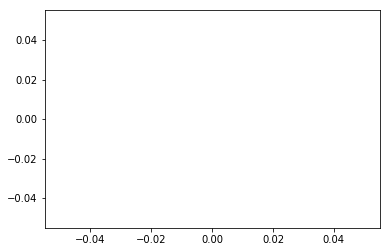

In [47]:
#plt.plot([i for i in range(len(loss_track))], loss_track)
plt.plot([i for i in range(len(dev_loss_track))], dev_loss_track)

plt.show()

In [56]:
df_all_dev.values[0][0]

[7344, 2675, 10099, 3520, 8791, 6626, 3956, 5961, 7647, 6626, 1]

In [228]:
int(3.2)

3

In [46]:
#Create inference
mean_metric = []
chunk_size = 500
n_chunks = int(df_all_train.shape[0]/chunk_size)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(session, \
'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10_test-119')
    for chunk in range(n_chunks):
        print (chunk, n_chunks)
        #fd = make_inference_inputs(
        #    [i for i in df_all_train['alpha_Pair_0_encoding'].values[chunk*chunk_size:(chunk+1)*chunk_size]])
        fd = make_inference_inputs(
            [numericEncode('get the report finished')])

        inf_out = session.run(decoder_prediction_inference, fd)
        inf_prob_out = session.run(decoder_prediction_prob_inference, fd)

        print(inf_out.T)
        #print (df_all_train.values[0][1], df_all_train.values[1][1])

        for i, (e_in, dt_inf) in enumerate(zip(fd[encoder_inputs].T, inf_out.T)):
            #mean_metric.append([df_all_train.values[i][0], df_all_train.values[i][1], dt_inf])
            print('    sample {}:'.format(i + 1))
            print('    enc input                > {}'.format([inv_map[k] for k in e_in]))
            #print('    dec input                > {}'.format([inv_map[k] for k in df_all_train.values[i][1]]))
            print('    dec train inference      > {}'.format([inv_map[k] for k in dt_inf]))
            print('    dec train inference prob > {}'.format([inf_prob_out[j][i].max() for j in range((len(inf_prob_out)))]))
            
            if i>0: continue
        
       # print ('Save Model')
       # builder = tf.saved_model.builder.SavedModelBuilder('d:\coding\seq2seq\model')
       # builder.add_meta_graph_and_variables(session, ['serve'])

        #builder.save()
    ops = session.graph.get_operations()

    feed_ops = [op for op in ops if op.type=='Placeholder']

    print(feed_ops)
        #if n_chunks >0: 
         #   break        

0 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train inference      > ['<EOS>']
    dec train inference prob > [0.065935388]
1 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train inference      > ['<EOS>']
    dec train inference prob > [0.065935366]
2 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train inference      > ['<EOS>']
    dec train inference prob > [0.065935366]
3 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train inference      > ['<EOS>']
    dec train inference prob > [0.065935396]
4 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train inference      > ['<EOS>']
    dec train inference prob > [0.065935366]
5 7
[[1]]
    sample 1:
    enc input                > ['get', 'the', 'report', 'finished']
    dec train infe

In [47]:
with tf.Session() as session:
    
    # We import the meta graph in the current default Graph
    saver = tf.train.import_meta_graph('d:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10_test-119.meta')

    # We restore the weights
    saver.restore(session, 'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10_test-119')
    

ValueError: No op named attn_add_fun_f32f32f32 in defined operations.

In [69]:
df_metric = pd.DataFrame(mean_metric, columns=['input', 'output', 'inference'])

In [76]:
#df_metric['truth_sent'] = df_metric[1].apply(decodeSent)
df_metric['inference_sent'] = df_metric['inference'].apply(decodeSent)

In [78]:
checkListResults = list(map(checkList, df_metric['output'].values, df_metric['inference_sent'].values))

df_metric['checkList'] = checkListResults

df_metric['meanCheckList'] = df_metric['checkList'].apply(np.mean)

In [79]:
df_metric

,input,output,inference,inference_sent,checkList,meanCheckList
0,"[reporting, agency, and, data, source, informa...","[enron, capital, trade, resources, corp, repor...","[4880, 3447, 3619, 4536, 86, 3748, 3446, 4533,...","[enron, capital, trade, resources, corp, repor...","[True, True, True, True, True, True, True, Tru...",1.000000
1,"[we, don, t, hear, from, him, by, noon, i, wou...","[be, cut, off, this, cold, november, any, prob...","[3249, 1422, 6289, 175, 4302, 1461, 1397, 4683...","[be, cut, off, this, cold, november, any, prob...","[True, True, True, True, True, True, True, Tru...",1.000000
2,"[month, changes, they, re, very, simple, to, m...","[these, are, done, <EOS>]","[6818, 6826, 1747, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[these, are, done, <EOS>, <PAD>, <PAD>, <PAD>,...","[True, True, True, True]",1.000000
3,"[subject, re, dinner, on, friday, ?, subject, ...","[subject, re, dinner, on, friday, ?, subject, ...","[2126, 6792, 6346, 1654, 325, 2222, 2126, 6792...","[subject, re, dinner, on, friday, ?, subject, ...","[True, True, True, True, True, True, True, Tru...",1.000000
4,"[thanksi, have, no, revisions, enjoy, the, par...","[and, positions, circulate, the, plan, early, ...","[4533, 6637, 2496, 208, 259, 1521, 175, 1306, ...","[and, positions, circulate, the, plan, early, ...","[True, True, True, True, True, True, True, Tru...",1.000000
5,"[attached, dealing, with, a, us, counterparty,...","[anytime, attached, dealing, with, a, us, coun...","[4998, 1970, 5463, 2589, 5934, 5674, 6467, 222...","[anytime, attached, dealing, with, a, us, coun...","[True, True, True, True, True, True, True, Tru...",1.000000
6,"[felt, that, out, of, shape, so, what, are, yo...","[is, the, filename, tran, enron, north, americ...","[1384, 208, 1676, 6159, 4880, 3837, 3576, 86, ...","[is, the, filename, tran, enron, north, americ...","[True, True, True, True, True, True, True, Tru...",1.000000
7,"[my, comments, on, bob, s, memo, thanks, <EOS>]","[office, number, <EOS>]","[2315, 6460, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[office, number, <EOS>, <PAD>, <PAD>, <PAD>, <...","[True, True, True]",1.000000
8,"[let, you, know, when, they, settle, it, prebo...","[but, we, should, know, soon, i, ll, e, mail, ...","[595, 4780, 4399, 3832, 3973, 439, 1179, 1450,...","[but, we, should, know, soon, i, ll, e, mail, ...","[True, True, True, True, True, True, True, Tru...",1.000000
9,"[likewise, so, who, is, the, lucky, person, fo...","[think, a, develop, engineer, initialled, for,...","[5675, 5934, 2305, 2431, 3475, 2881, 1799, 152...","[think, a, develop, engineer, initialled, for,...","[True, True, True, True, True, True, True, Tru...",1.000000


In [86]:
df_metric[df_metric['meanCheckList']==0][['input', 'output', 'inference_sent']].values

array([[list(['how', 'about', '?', '<EOS>']),
        list(['yea', 'how', 'about', '?', '<EOS>']),
        list(['has', 'the', 'counterparty', 'ever', 'signed', 'confirms', '?', 'would', 'you', 'be', 'interested', 'in', 'meeting', 'today', 'at', '?', 'i', 'll', 'keep', 'you', 'updated', 'any', 'luck', 'with', 'morgan', 'williams', 'or', 'any', 'other', 'updates', '?', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'])],
       [list(['thanks', 'you', 're', 'the', 'best', '<EOS>']),
        list(['thanks', 'see', 'you', 'tonite', 'looking', 'forward', 'to', 'it', '<EOS>']),
        list(['dan', 'it', 'will', 'have', 'to', 'wait', 'i', 'will', 'be', 'back', 'in', 'early', 'january', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

In [68]:
df_metric

,input,output,input_onehot
0,"[reporting, agency, and, data, source, informa...","[enron, capital, trade, resources, corp, repor...","[4880, 3447, 3619, 4536, 86, 3748, 3446, 4533,..."
1,"[we, don, t, hear, from, him, by, noon, i, wou...","[be, cut, off, this, cold, november, any, prob...","[3249, 1422, 6289, 175, 4302, 1461, 1397, 4683..."
2,"[month, changes, they, re, very, simple, to, m...","[these, are, done, <EOS>]","[6818, 6826, 1747, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[subject, re, dinner, on, friday, ?, subject, ...","[subject, re, dinner, on, friday, ?, subject, ...","[2126, 6792, 6346, 1654, 325, 2222, 2126, 6792..."
4,"[thanksi, have, no, revisions, enjoy, the, par...","[and, positions, circulate, the, plan, early, ...","[4533, 6637, 2496, 208, 259, 1521, 175, 1306, ..."
5,"[attached, dealing, with, a, us, counterparty,...","[anytime, attached, dealing, with, a, us, coun...","[4998, 1970, 5463, 2589, 5934, 5674, 6467, 222..."
6,"[felt, that, out, of, shape, so, what, are, yo...","[is, the, filename, tran, enron, north, americ...","[1384, 208, 1676, 6159, 4880, 3837, 3576, 86, ..."
7,"[my, comments, on, bob, s, memo, thanks, <EOS>]","[office, number, <EOS>]","[2315, 6460, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[let, you, know, when, they, settle, it, prebo...","[but, we, should, know, soon, i, ll, e, mail, ...","[595, 4780, 4399, 3832, 3973, 439, 1179, 1450,..."
9,"[likewise, so, who, is, the, lucky, person, fo...","[think, a, develop, engineer, initialled, for,...","[5675, 5934, 2305, 2431, 3475, 2881, 1799, 152..."


In [244]:
(df_metric['truth'].values, df_metric['inference'].values)

(array([list([8656, 5, 531, 4913, 4591, 2407, 4031, 8934, 2881, 6626, 1]),
        list([3956, 280, 7068, 1599, 7647, 12339, 13500, 3956, 12460, 1]),
        list([11050, 10624, 4031, 3309, 10007, 2289, 10364, 399, 11178, 1]),
        ..., list([3635, 12049, 12460, 3894, 1267, 1696, 3849, 6626, 1]),
        list([12339, 9585, 2376, 679, 80, 12339, 5567, 4911, 856, 3956, 1]),
        list([12339, 7167, 4911, 169, 1696, 4150, 8076, 6796, 2450, 12339, 5708, 3956, 1])], dtype=object),
 array([ array([8656,    5,  531, 4913, 4591, 2407, 4031, 8934, 2881, 6626,    1,
           0,    0,    0,    0,    0,    0], dtype=int64),
        array([ 3956, 12460,  7068,  1599,  7647, 12339, 13500,  3956,  3849,
            1,     0,     0,     0,     0,     0,     0,     0], dtype=int64),
        array([11050, 10364,  3309,  4157,  2615,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0], dtype=int64),
        ...,
        array([ 3651,   280, 12709,  8728,    

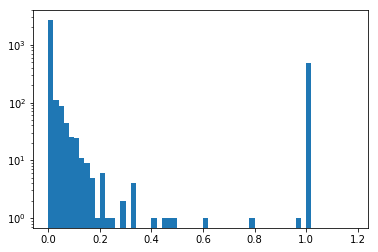

In [84]:
plt.hist(df_metric['meanCheckList'].values, bins=[i/50 for i in range(60)], log=True)
plt.show()

In [184]:
def padList(x, y):
    
    pad_length = max(len(x), len(y))
    
    print (pad_length)
    
    if len(x)> len(y): 
        print ('a')
        y = y + [0]
    elif len(x) < len(y): 
        print ('b')
        x = x + [0]
    
    
    print (x)
    return x, y

In [208]:
df_all_train

,alpha_Pair_0_encoding,alpha_Pair_1_encoding,alpha_Pair_1_encoding_reverse_order,Index
11022,"[280, 6242, 4031, 11099, 6626, 1]","[8656, 5, 531, 4913, 4591, 2407, 4031, 8934, 2...","[1, 6626, 2881, 8934, 4031, 2407, 4591, 4913, ...",11022
84499,"[3651, 280, 10537, 7470, 8084, 11845, 4057, 1]","[3956, 280, 7068, 1599, 7647, 12339, 13500, 39...","[1, 12460, 3956, 13500, 12339, 7647, 1599, 706...",84499
27462,"[13272, 13044, 1195, 3849, 3956, 273, 12437, 6...","[11050, 10624, 4031, 3309, 10007, 2289, 10364,...","[1, 11178, 399, 10364, 2289, 10007, 3309, 4031...",27462
25199,"[531, 181, 8206, 6336, 3849, 3956, 9746, 6626, 1]","[12339, 3140, 10500, 6744, 1]","[1, 6744, 10500, 3140, 12339]",25199
102362,"[12049, 6626, 12049, 7344, 7346, 6626, 1]","[7346, 1347, 5092, 8765, 695, 7647, 1696, 1161...","[1, 2675, 3956, 6890, 531, 11610, 1696, 7647, ...",102362
90493,"[9746, 3956, 7140, 1856, 6626, 1]","[11050, 11487, 8766, 13217, 8018, 13272, 1347,...","[1, 6626, 11845, 1347, 13272, 8018, 13217, 876...",90493
55216,"[6796, 8286, 6381, 10805, 2446, 4116, 1347, 12...","[11968, 6381, 325, 695, 4613, 4157, 4031, 1034...","[1, 13489, 10341, 4031, 4157, 4613, 695, 325, ...",55216
73043,"[12339, 5411, 3956, 1637, 4031, 897, 6612, 495...","[3956, 6600, 4911, 11398, 552, 10274, 12049, 5...","[1, 10394, 5240, 12049, 10274, 552, 11398, 491...",73043
21499,"[531, 3956, 13500, 2675, 695, 5240, 2985, 6626...","[11355, 3956, 2143, 4031, 10516, 8078, 11625, ...","[1, 6626, 10060, 1577, 11852, 11625, 8078, 105...",21499
96307,"[3956, 169, 1696, 10394, 1599, 11489, 6626, 1]","[12887, 4911, 7714, 8240, 12887, 4911, 7714, 1]","[1, 7714, 4911, 12887, 8240, 7714, 4911, 12887]",96307


In [83]:
#tf.Session().run(tf.equal(inf_out.T[1], df_all_train['alpha_Pair_1_encoding'].values[:2][1]))

In [122]:
tf.Session().run(tf.pad(t, paddings, "CONSTANT"))

array([[ 8656,     5,   531,  4913,  4591,  2407,  4031,  8934,  2881,
         6626,     1,     0],
       [ 3956, 12460,  7068,  1599,  7647, 12339, 13500,  3956,  3849,
            1,     0,     0]], dtype=int64)

In [121]:
t = inf_out.T
paddings = [[0, 0], [0, 1]]

In [123]:
 inf_out.T

array([[ 8656,     5,   531,  4913,  4591,  2407,  4031,  8934,  2881,
         6626,     1],
       [ 3956, 12460,  7068,  1599,  7647, 12339, 13500,  3956,  3849,
            1,     0]], dtype=int64)

In [98]:
tf.shape([df_all_train['alpha_Pair_1_encoding'].values[:2][1]])

<tf.Tensor 'Shape_3:0' shape=(2,) dtype=int32>

In [85]:
pad_length = max(len(df_all_train['alpha_Pair_1_encoding'].values[:2][1]), len(inf_out.T[1]))

In [84]:
len(df_all_train['alpha_Pair_1_encoding'].values[:2][1]), len(inf_out.T[1])

(10, 11)

In [79]:
tf.equal(inf_out.T[0], df_all_train['alpha_Pair_1_encoding'].values[:2][0])

<tf.Tensor 'Equal_4:0' shape=(11,) dtype=bool>

In [146]:
#tf.Session().run(tf.equal([x0, x1], [y0, y1]))

In [ ]:
decoder_train_targets_eos_mask = tf.one_hot(decoder_train_length - 1,
                                                        decoder_train_targets_seq_len,
                                                        on_value=EOS, off_value=PAD,
                                                        dtype=tf.int32)

In [66]:
#Freeze Model
with tf.Session() as session:
    #session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver = tf.train.import_meta_graph(
#'d:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10-119.meta')

    saver.restore(session, \
'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10-119')
    
#with tf.Session(graph=tf.Graph()) as sess:
   # sess.run(tf.global_variables_initializer())

    # We import the meta graph in the current default Graph
      # We restore the weights
   # saver.restore(sess, 'd:\coding\seq2seq\chkpt\seq2seq_enron_encode_128_decode_256_vocab_7239_embedding_256_seq_3_49_batch_32_layers_2_enkeep_10_dekeep_10-119')
  

#    # We use a built-in TF helper to export variables to constants
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        session, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        ['Decoder/dynamic_rnn_decoder/Decoder/while/attention_decoder/Softmax', 
         'Decoder/dynamic_rnn_decoder_1/Decoder/while/attention_decoder_fn_inference/Softmax'])
                # The output node names are used to select the usefull nodes
 #   ) 
    
    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile('frozen_model.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
    
    print("%d ops in the final graph." % len(output_graph_def.node))

INFO:tensorflow:Froze 19 variables.
Converted 19 variables to const ops.
731 ops in the final graph.


In [ ]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    dir(tf.contrib.legacy_seq2seq.attention_decoder)
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

load_graph('frozen_model.pb')